In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
import warnings


In [365]:
#Aquiring stock data of Apple
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.index = tickerDf.index.tz_localize(None)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03,33.768538,33.864876,33.613452,33.766186,79942800,0.0,0.0
2017-04-04,33.660447,34.045809,33.641648,34.017612,79565600,0.0,0.0
2017-04-05,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06,33.904819,33.958867,33.707440,33.756786,84596000,0.0,0.0
2017-04-07,33.773228,33.878967,33.665141,33.681587,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0
2022-05-25,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0


In [425]:
#Aquiring every rates from federal reserve interest rate data + initial cleaning
frData=pd.read_csv('src/FRB_H15.csv')
frData.columns = ['Date','Federal funds Rate','Prime Rate','Discount Rate']
frData = frData[5:]
frData = frData.reset_index(drop=True)
frData = frData.set_index('Date')

# seperating the discount rate data , converting date to datetime and values to float
discountRate = frData.copy()
#discountRate.columns = ['Discount Rate']
discountRate.index = pd.to_datetime(discountRate.index)
discountRate = discountRate.astype({'Discount Rate': 'float','Prime Rate': 'float','Federal funds Rate': 'float'})
discountRate

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2016-08-03,0.36,3.50,1.00
2016-08-10,0.40,3.50,1.00
2016-08-17,0.40,3.50,1.00
2016-08-24,0.40,3.50,1.00
2016-08-31,0.39,3.50,1.00
...,...,...,...
2022-06-29,1.58,4.75,1.75
2022-07-06,1.58,4.75,1.75
2022-07-13,1.58,4.75,1.75


In [426]:
# resampling data and interpolating missing values using pad and setting type as float

discountRate = pd.DataFrame(discountRate.resample('1d').sum())

discountRate[discountRate == 0] = None
discountRate = discountRate.interpolate(method='time') 

discountRate = pd.DataFrame(discountRate['2017-04-03':'2022-05-31'])


#dont need to do differencing is arimax does it automatically
discountRate

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2017-04-03,0.881429,4.0,1.5
2017-04-04,0.875714,4.0,1.5
2017-04-05,0.870000,4.0,1.5
2017-04-06,0.875714,4.0,1.5
2017-04-07,0.881429,4.0,1.5
...,...,...,...
2022-05-27,0.830000,4.0,1.0
2022-05-28,0.830000,4.0,1.0
2022-05-29,0.830000,4.0,1.0


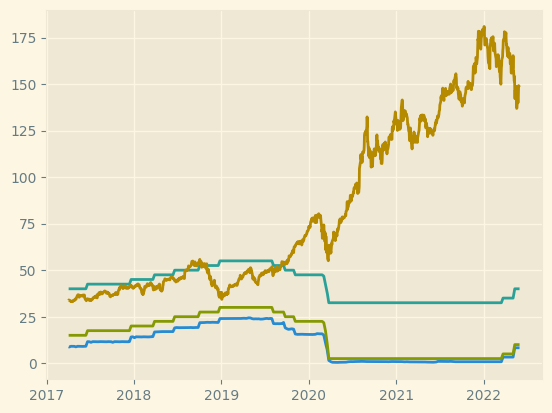

In [427]:
plt.plot(discountRate*10)
plt.plot(tickerDf['Close'])
# interest rates stay stable during prediction period so have little affect or correlation to close price
#interest rate would have more effect on monthly predictions

In [428]:
discountRate[0:50]

,Federal funds Rate,Prime Rate,Discount Rate
Date,,,
2017-04-03,0.881429,4.0,1.5
2017-04-04,0.875714,4.0,1.5
2017-04-05,0.870000,4.0,1.5
2017-04-06,0.875714,4.0,1.5
2017-04-07,0.881429,4.0,1.5
2017-04-08,0.887143,4.0,1.5
2017-04-09,0.892857,4.0,1.5
2017-04-10,0.898571,4.0,1.5
2017-04-11,0.904286,4.0,1.5


In [366]:
tickerDfResample = pd.DataFrame(tickerDf.resample('1d').sum())
tickerDfResample[tickerDfResample == 0] = None
tickerDfResample = tickerDfResample.interpolate(method='pad')
tickerDfResample = np.log(tickerDfResample)
tickerDfResample

first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
tickerDfResample['PercentageChange'] = tickerDfResample.Close.pct_change().fillna(0) #  "by what percentage did previous value change to get to current value"current value - previous value / previous value = pct change
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference,PercentageChange
Date,,,,,,,,,
2017-04-03,3.519530,3.522378,3.514926,3.519460,18.196822,NaN,NaN,0.007419,0.000000
2017-04-04,3.516323,3.527707,3.515765,3.526878,18.192092,NaN,NaN,-0.005194,0.002108
2017-04-05,3.523072,3.531633,3.520225,3.521684,18.523883,NaN,NaN,-0.002503,-0.001473
2017-04-06,3.523557,3.525150,3.517719,3.519181,18.253398,NaN,NaN,-0.002230,-0.000711
2017-04-07,3.519668,3.522794,3.516463,3.516951,18.015548,NaN,NaN,0.000000,-0.000634
...,...,...,...,...,...,...,...,...,...
2022-05-27,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.008046
2022-05-28,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000
2022-05-29,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000


In [157]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2017-04-03 to 2022-05-31
Freq: D
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1885 non-null   float64
 1   High              1885 non-null   float64
 2   Low               1885 non-null   float64
 3   Close             1885 non-null   float64
 4   Volume            1885 non-null   float64
 5   Dividends         1847 non-null   float64
 6   Stock Splits      639 non-null    float64
 7   FirstDifference   1885 non-null   float64
 8   PercentageChange  1885 non-null   float64
dtypes: float64(9)
memory usage: 147.3 KB


In [168]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)
        
ad_test(tickerDfResample['FirstDifference'])

1. ADF:  -11.323707593725075
2. P_value:  1.1572945868218323e-20
3. num_lags:  12
4. :  1872
5. crit_value:  {'1%': -3.4338480179204556, '5%': -2.863085177979608, '10%': -2.567592596439203}
	 1% :  -3.4338480179204556
	 5% :  -2.863085177979608
	 10% :  -2.567592596439203


In [344]:
discountRate[['Discount Rate']]

,Discount Rate
Date,
2017-04-03,0.0
2017-04-04,0.0
2017-04-05,1.5
2017-04-06,0.0
2017-04-07,0.0
...,...
2022-05-27,0.0
2022-05-28,0.0
2022-05-29,0.0


In [429]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample[['Close']],X=discountRate[['Discount Rate']],trace=True,suppress_warnings=False )
stepwise_fit.summary()
#gives stroger coeffecient for discount rate as it affects prices more
#might be inaccurate for short term but doing interest rate predictions for future will provide more accurate long term trends for future

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10140.618, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10125.562, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10146.276, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10146.787, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10123.172, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10144.784, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10144.799, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10142.845, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10143.179, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.465 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5077.394
Date:                Wed, 25 Jan 2023   AIC                         -10146.787
Time:                        13:55:26   BIC                         -10124.623
Sample:                    04-03-2017   HQIC                        -10138.624
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0008      0.000      2.241      0.025    9.87e-05       0.001
Discount Rate     0.0320      0.011      3.028      0.002       0.011       0.053
ma.L1            -0.1113      0.016     -6.782      0.000      -0.144      -0.079
sigma2            0.0003   3.83e-06     69.795      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6918.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [368]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample[['Close']],trace=True,suppress_warnings=False )
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10141.491, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10126.275, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10146.911, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10147.332, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10123.981, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10145.317, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10145.326, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10143.355, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10143.854, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.783 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5076.666
Date:                Wed, 25 Jan 2023   AIC                         -10147.332
Time:                        13:18:55   BIC                         -10130.709
Sample:                    04-03-2017   HQIC                        -10141.210
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.288      0.022       0.000       0.001
ma.L1         -0.1110      0.015     -7.294      0.000      -0.141      -0.081
sigma2         0.0003    3.7e-06     72.150      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7190.55
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

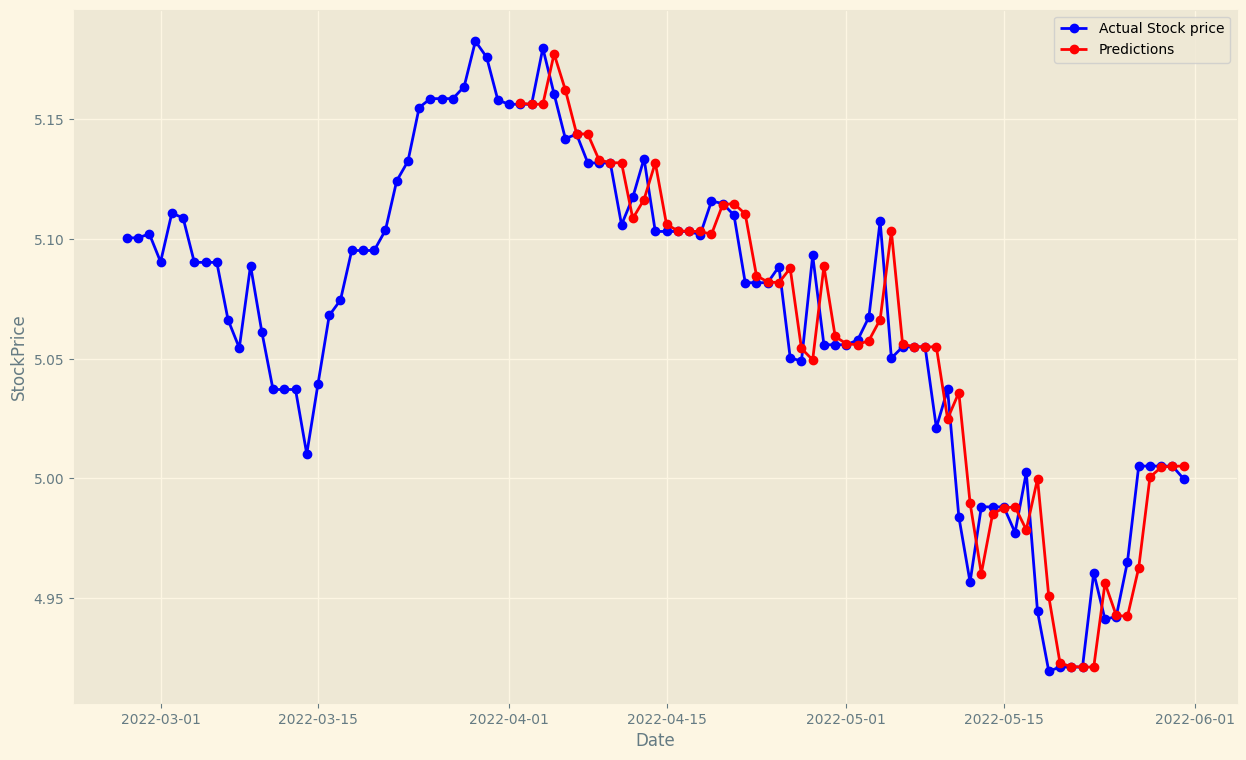

The root mean squared error is:  0.16770517895521891


In [394]:
#close price prediction using SARIMAX
trainData = tickerDfResample['Close'][0:1825]
testData = pd.DataFrame(tickerDfResample['Close'][1825:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = SARIMAX(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast()
    #futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
   
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))

In [341]:
np.std(testData)

Close          0.070722
Predictions    0.071407
dtype: float64

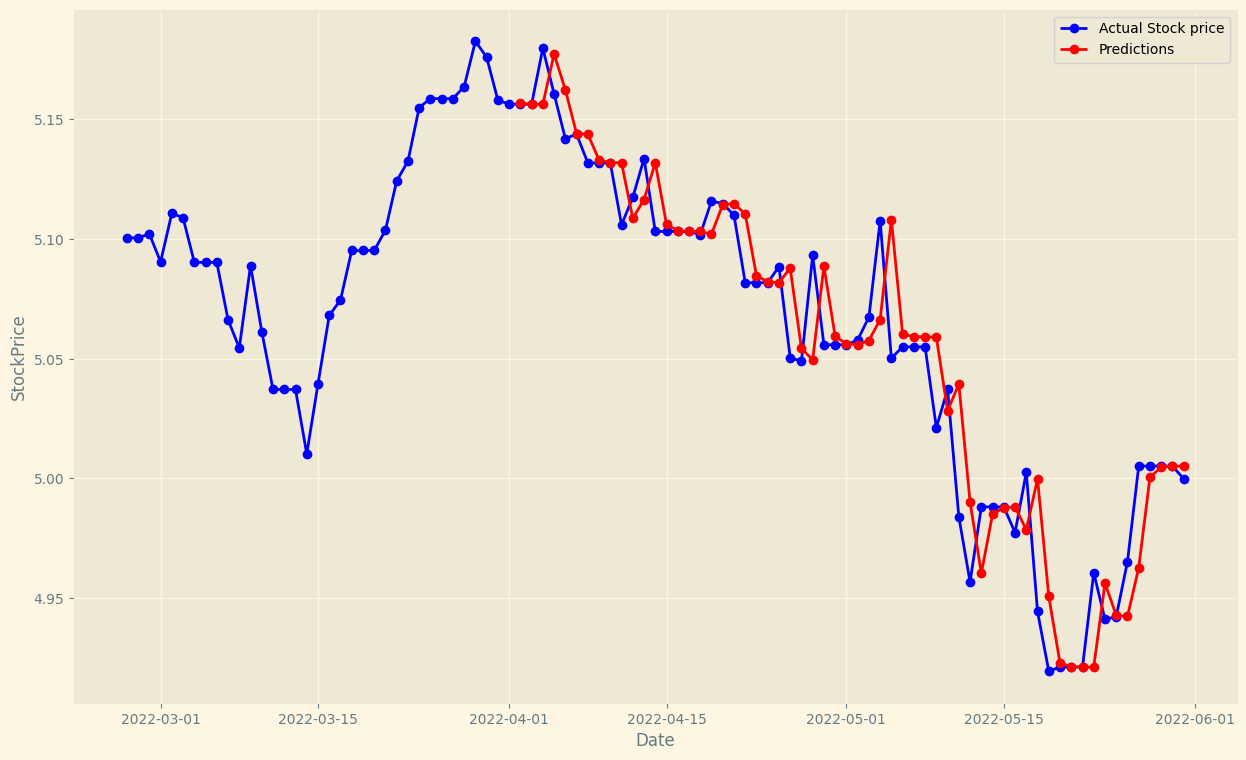

The root mean squared error is:  0.17128090330832466


In [430]:
#close price prediction using exogenous variables

trainData = tickerDfResample['Close'][0:1825]
trainDataExog = discountRate[0:1825]['Discount Rate']   
testData = pd.DataFrame(tickerDfResample['Close'][1825:])
testDataExog =  pd.DataFrame(discountRate[1825:]['Discount Rate'] )   
testData['Predictions'] = 0

for i in range(len(testData)):
    model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0,1,1))
    modelFit = model.fit()

    futureForcast = modelFit.forecast(exog = testDataExog['Discount Rate'][i:i+1])
    #futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    trainDataExog = trainDataExog.append(testDataExog['Discount Rate'][i:i+1])
    trainDataExog = trainDataExog[1:] 
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close']-testData['Predictions']))))

In [343]:
np.std(testData)

Close          0.070722
Predictions    0.071428
dtype: float64

In [380]:
testDataExog # interest rates stay stable during this period so have no predictive power

,Discount Rate
Date,
2022-04-02,0.0
2022-04-03,0.0
2022-04-04,0.0
2022-04-05,0.0
2022-04-06,0.5
2022-04-07,0.0
2022-04-08,0.0
2022-04-09,0.0
2022-04-10,0.0


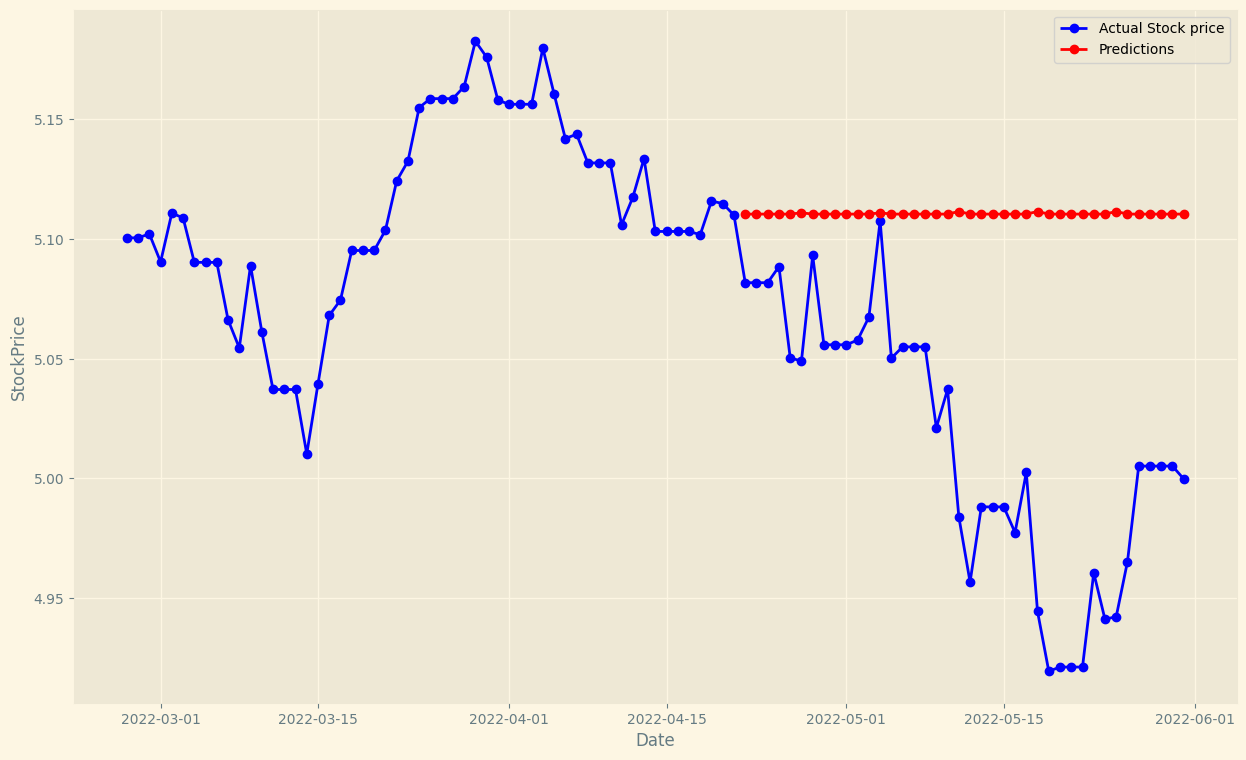

The root mean squared error is:  0.02866044878186358


In [323]:
#forcast price prediction using exogenous variables

trainData = tickerDfResample['Close'][0:1845]
trainDataExog = discountRate['Discount Rate'][0:1845]   
testData = pd.DataFrame(tickerDfResample['Close'][1845:])
testDataExog =  pd.DataFrame(discountRate['Discount Rate'][1845:] )   
testData['Predictions'] = 0


model = SARIMAX(endog=trainData,exog=trainDataExog,order=(0,1,1))
modelFit = model.fit()

futureForcast = modelFit.forecast(len(testData) , exog = testDataExog)

testData['Predictions']=futureForcast
    
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close'][0:1]-testData['Predictions'][0:1]))))

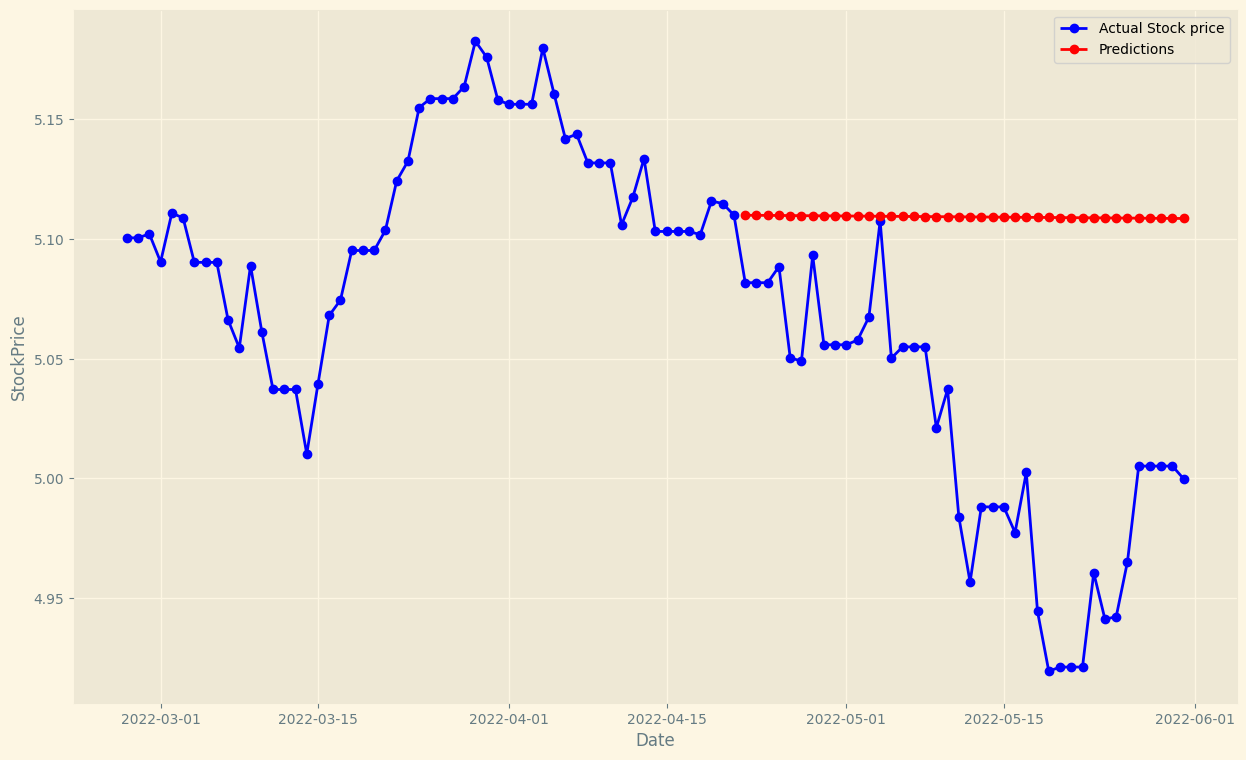

The root mean squared error is:  0.02818055336395453


In [324]:
#forcast price prediction withought exogenous variables

trainData = tickerDfResample['Close'][0:1845]
 
testData = pd.DataFrame(tickerDfResample['Close'][1845:])

testData['Predictions'] = 0


model = SARIMAX(endog=trainData)
modelFit = model.fit()

futureForcast = modelFit.forecast(len(testData))

testData['Predictions']=futureForcast
    
    
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show()
print("The root mean squared error is: ",np.sqrt(np.sum(np.square(testData['Close'][0:1]-testData['Predictions'][0:1]))))

In [187]:
#Fbprophet prediction
df = pd.DataFrame(tickerDfResample['Close'][0:1250]).reset_index()
df.columns = ['ds','y']
df['ds'] = df['ds'].dt.tz_localize(None)
testData = pd.DataFrame(tickerDfResample['Close'][1250:])

model = Prophet()
model.fit(df)

11:50:15 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


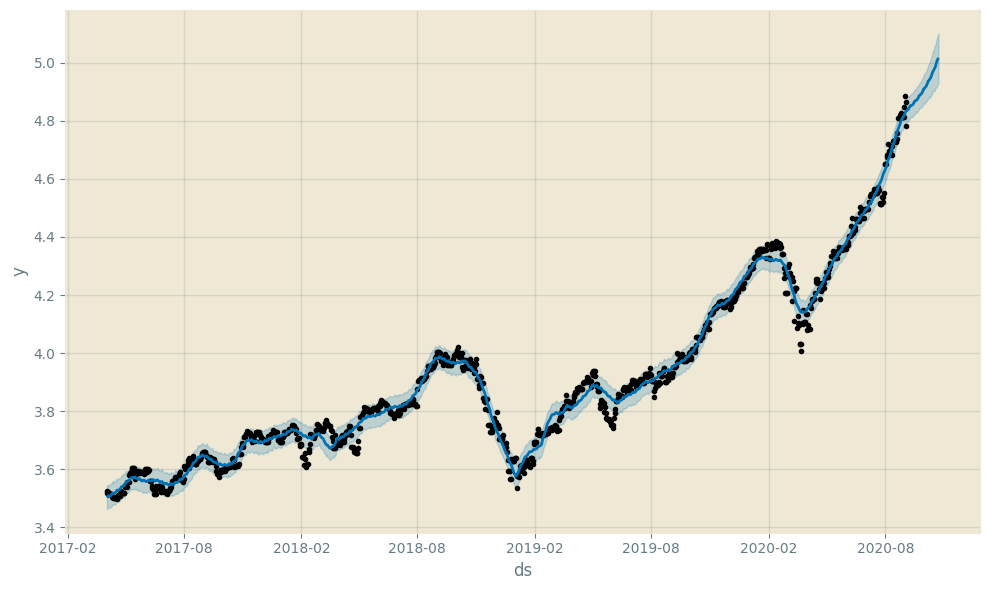

In [188]:
futureDates = model.make_future_dataframe(periods = 50)
prediction = model.predict(futureDates)
fig = model.plot(prediction)